### Import the dataset
It is built into keras so we can easily import

In [86]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

### Check the data sizes 

In [87]:
rows, cols = train_data.shape
print("There are " +str(rows) + " examples/rows and " + str(cols) + " features/columns in the training set")

There are 404 examples/rows and 13 features/columns in the training set


### Preprocess the data by Z-score normalization
In this way, the gradients will not become too large or too small and vanish
So we will subtract the mean and divide by the standard deviation

In [88]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [89]:
import numpy as np
print("mean of the processed train data is: " + str(np.mean(train_data)))
print("std of the processed train data is: " + str(np.std(train_data)))

mean of the processed train data is: 2.602301889250862e-15
std of the processed train data is: 0.9999999999999994


### Build the neural network 
The architecture we've chosen to use has 3 layers.
<br>The first hidden layer has 64 neurons. 
<br> The second hidden layer has 64 neurons. 
<br>The output layer is just one neuron and no activations because we want to predict a real number

The loss function is the Mean Squared Error and we are optimizing it with RMSPROP. 
<br> We will monitor the minimization of the error by looking at the Mean Absolute Error everytime. 
<br> Check out the [Keras](https://faroit.github.io/keras-docs/0.2.0/optimizers/) documentation for various optimizers and default parameters.

In [104]:
from keras.models import Sequential
from keras.layers import Dense, Activation

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### Let's build the model 

In [105]:
model = build_model()
history = model.fit(train_data,train_targets, batch_size=16, epochs=80, verbose=1)
# If you don't want to see how the model is doing as it's training, change verbose=0

Epoch 1/80
404/404 [==============================] - 0s 974us/step - loss: 507.1620 - mean_absolute_error: 20.6547
Epoch 2/80
404/404 [==============================] - 0s 128us/step - loss: 334.8835 - mean_absolute_error: 16.0584
Epoch 3/80
404/404 [==============================] - 0s 163us/step - loss: 162.9401 - mean_absolute_error: 10.1049
Epoch 4/80
404/404 [==============================] - 0s 141us/step - loss: 79.8484 - mean_absolute_error: 6.5115
Epoch 5/80
404/404 [==============================] - 0s 128us/step - loss: 50.0214 - mean_absolute_error: 5.2190
Epoch 6/80
404/404 [==============================] - 0s 187us/step - loss: 33.2833 - mean_absolute_error: 4.1909
Epoch 7/80
404/404 [==============================] - 0s 175us/step - loss: 24.7300 - mean_absolute_error: 3.5018
Epoch 8/80
404/404 [==============================] - 0s 206us/step - loss: 21.3383 - mean_absolute_error: 3.2762
Epoch 9/80
404/404 [==============================] - 0s 171us/step - loss: 19.031

404/404 [==============================] - 0s 128us/step - loss: 6.3741 - mean_absolute_error: 1.7546
Epoch 73/80
404/404 [==============================] - 0s 124us/step - loss: 6.3351 - mean_absolute_error: 1.8106
Epoch 74/80
404/404 [==============================] - 0s 160us/step - loss: 6.1891 - mean_absolute_error: 1.7401
Epoch 75/80
404/404 [==============================] - 0s 227us/step - loss: 6.2123 - mean_absolute_error: 1.7760
Epoch 76/80
404/404 [==============================] - 0s 197us/step - loss: 6.1492 - mean_absolute_error: 1.7426
Epoch 77/80
404/404 [==============================] - 0s 218us/step - loss: 6.2090 - mean_absolute_error: 1.7330
Epoch 78/80
404/404 [==============================] - 0s 157us/step - loss: 5.9969 - mean_absolute_error: 1.7167
Epoch 79/80
404/404 [==============================] - 0s 149us/step - loss: 6.1365 - mean_absolute_error: 1.7135
Epoch 80/80
404/404 [==============================] - 0s 193us/step - loss: 6.1419 - mean_absolute_

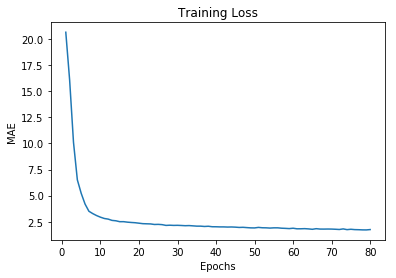

In [106]:
import matplotlib.pyplot as plt
loss = history.history['mean_absolute_error']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()


In [107]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print("The error on the test set is: ", test_mse_score)
print("This means we are off by $", test_mse_score*1000)

102/102 [==============================] - 0s 2ms/step
The error on the test set is:  18.545385921702664
This means we are off by $ 18545.385921702666


### Our model sucks!
It will make predictions that are off by $ 10,000 which is bad considering that prices of houses are in the 10,000s. 
<br> Let's try training with a validation set!
<img src="val.png"> 

In [95]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [109]:
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis=0)
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples], 
                                             train_targets[(i + 1) * num_val_samples:]],
                                             axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)

processing fold # 0
101/101 [==============================] - 0s 2ms/step
processing fold # 1
101/101 [==============================] - 0s 3ms/step
processing fold # 2
101/101 [==============================] - 0s 3ms/step
processing fold # 3
101/101 [==============================] - 0s 2ms/step


In [111]:
all_scores

[2.2365968132963276,
 2.391238755518847,
 2.4638840207959167,
 2.6779959071980843,
 2.093541348334586,
 2.6171908378601074,
 2.596727420788,
 2.529279900069284]

In [112]:
np.mean(all_scores)

2.450806875482644